## Image segmentation using SAM


In [ ]:
!nvidia-smi

Fri Feb 28 15:19:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.6/218.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.9 MB/s eta 0:00:00


### Download SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Data from Github


In [ ]:
!git clone https://github.com/mvaldenegro/marine-debris-fls-datasets.git

Cloning into 'marine-debris-fls-datasets'...
remote: Enumerating objects: 13207, done.
remote: Total 13207 (delta 0), reused 0 (delta 0), pack-reused 13207 (from 1)
Receiving objects: 100% (13207/13207), 224.31 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (2170/2170), done.
Updating files: 100% (12921/12921), done.


In [ ]:
import PIL
import matplotlib.pyplot as plt

INPUT_SHAPE = 128
import cv2
import numpy as np

def preprocess_image(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    denoised = cv2.GaussianBlur(image, (5, 5), 0)
    normalized = denoised / 255.0

    return normalized


def load_data(path, shape):
    file_names = os.listdir(path)
    file_names.sort()
    if len(file_names) == 0:
      raise ValueError("No files found at path: " + path)

    frame_obj = {
      'img': [],
      'img_path': [],
    }


    for i, name in enumerate(file_names):
        if not name.endswith('.png'):
          continue
        img_path = path + '/' + name
        img = cv2.imread(img_path)
        #img = cv2.resize(img, (shape, shape))
        img = preprocess_image(img_path)
        frame_obj['img'].append(img)
        frame_obj['img_path'].append(img_path)

    return frame_obj

In [ ]:
can_data = load_data('/content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-segmentation/Images', shape=INPUT_SHAPE)

In [ ]:
len(can_data['img'])

1868

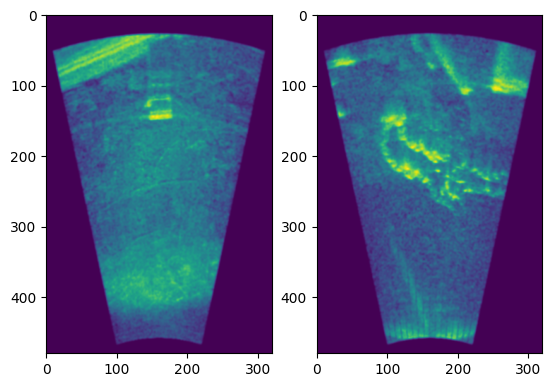

In [ ]:
# Display sample images (helps make sure everything was loaded correctly)
plt.subplot(1,2,1)
plt.imshow(can_data['img'][0])
plt.subplot(1,2,2)
plt.imshow(can_data['img'][1])
plt.show()

## Load Model

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
IMAGE_PATH =can_data['img_path'][1]

### Generate masks with SAM

In [ ]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

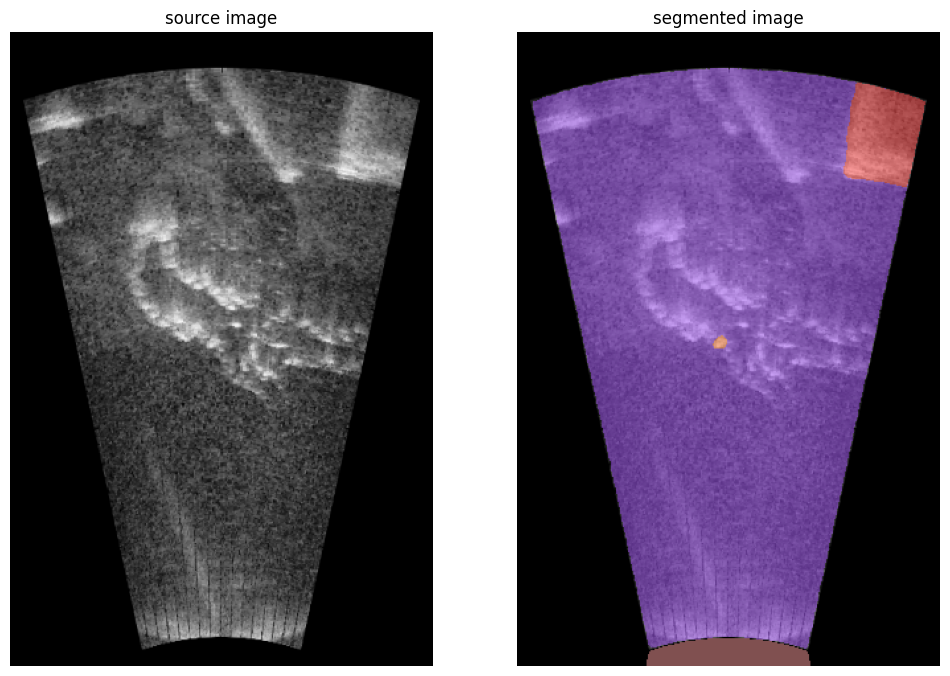

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

As seen in this example, the results are not very robust due to the noise in the image. The SAM model wasn't able to segment the image properly.

## Generate Segmentation with Bounding Box

In [ ]:
mask_predictor = SamPredictor(sam)

### Draw Box



In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 42, 'y': 107, 'width': 244, 'height': 187, 'label': ''}]

### Generate masks with SAM

Using the draw box technique, we were left with the box argument in the in `[x_min, y_min, x_max, y_max]` format.

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 60, 'y': 50, 'width': 206, 'height': 220, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

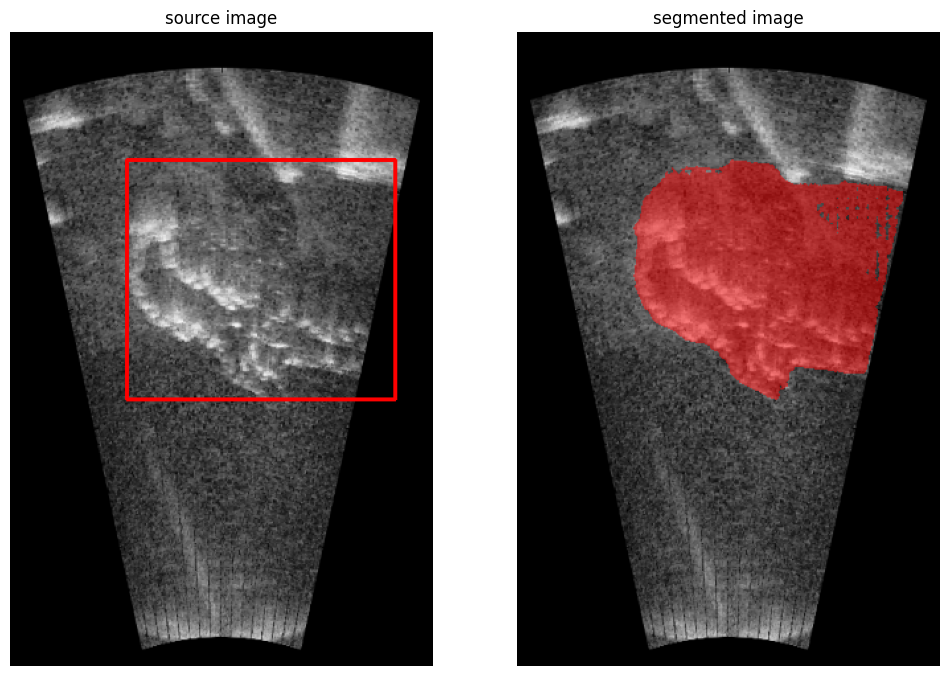

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks[:1]),  # Prend uniquement le premier masque
    mask=masks[:1]
)

detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

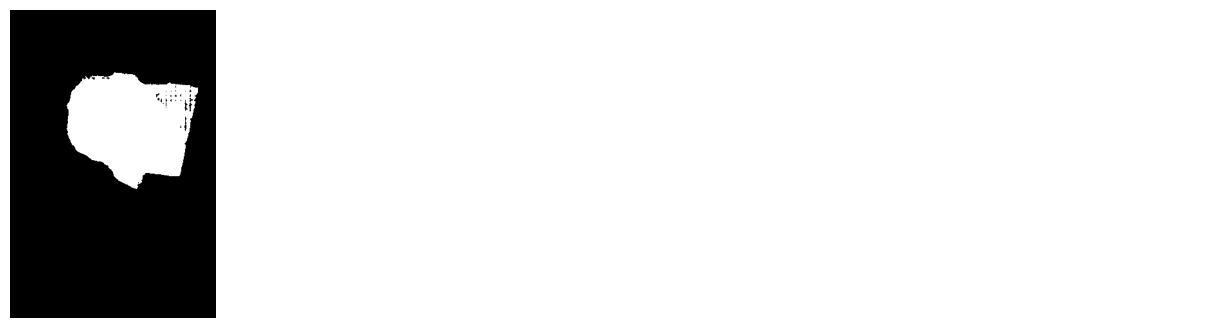

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks[:1],
    grid_size=(1, 4),
    size=(16, 4)
)

Using the bounding box technique, SAM was able to detect and extract the element from the image, providing the mask as the final output.

## Save The results

In [ ]:
import cv2
import numpy as np
import os
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64," + encoded

def process_images(can_data, mask_predictor, output_dir="output_masks"):
    os.makedirs(output_dir, exist_ok=True)

    for idx, image_path in enumerate(can_data['img_path']):
        print(f"Processing image {idx + 1}/{len(can_data['img_path'])}: {image_path}")

        image_bgr = cv2.imread(image_path)
        if image_bgr is None:
            print(f"Warning: Unable to read image {image_path}")
            continue

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        mask_predictor.set_image(image_rgb)

        # Utilisation d'une boîte par défaut si aucune n'est disponible
        default_box = {'x': 60, 'y': 50, 'width': 206, 'height': 220, 'label': ''}
        box = widget.bboxes[0] if widget.bboxes else default_box

        # Conversion du dictionnaire en liste [x1, y1, x2, y2]
        box_coords = [box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']]

        masks, scores, logits = mask_predictor.predict(
            box=np.array(box_coords),
            multimask_output=True
        )

        if masks.size == 0:
            print(f"No masks found for image {image_path}")
            continue

        first_mask = masks[0]
        mask_image = (first_mask * 255).astype(np.uint8)

        image_name = os.path.splitext(os.path.basename(image_path))[0]
        output_path = os.path.join(output_dir, f"mask_{image_name}.png")
        cv2.imwrite(output_path, mask_image)
        print(f"Mask saved to {output_path}")

    print("Processing complete.")


In [ ]:
process_images(can_data, mask_predictor)


Processing image 1/1868: /content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-segmentation/Images/marine-debris-aris3k-0.png
Mask saved to output_masks/mask_marine-debris-aris3k-0.png
Processing image 2/1868: /content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-segmentation/Images/marine-debris-aris3k-1.png
Mask saved to output_masks/mask_marine-debris-aris3k-1.png
Processing image 3/1868: /content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-segmentation/Images/marine-debris-aris3k-10.png
Mask saved to output_masks/mask_marine-debris-aris3k-10.png
Processing image 4/1868: /content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-segmentation/Images/marine-debris-aris3k-100.png
Mask saved to output_masks/mask_marine-debris-aris3k-100.png
Processing image 5/1868: /content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-segmentation/Images/marine-debris-aris3k-1000.png
Mask saved to output_masks/mask_marine-debris-aris3k-1000.png
Pro

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Mask saved to output_masks/mask_marine-debris-aris3k-759.png
Processing image 1603/1868: /content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-segmentation/Images/marine-debris-aris3k-76.png
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-283d6f8ce261>", line 1, in <cell line: 0>
    process_images(can_data, mask_predictor)
  File "<ipython-input-27-aba30efa7dc4>", line 24, in process_images
    mask_predictor.set_image(image_rgb)
  File "/usr/local/lib/python3.11/dist-packages/segment_anything/predictor.py", line 56, in set_image
    input_image = self.transform.apply_image(image)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/segment_anything/utils/transforms.py", line 31, in apply_image
    return np.array(resize(to_pil_image(image), target_size))
 

TypeError: object of type 'NoneType' has no len()

In [ ]:
from google.colab import drive
import shutil

drive.mount('/content/drive')

source_folder = "/content/output_masks"
destination_folder = "/content/drive/My Drive/data_mask"  # Chemin sur Google Drive

# Copier le dossier vers Google Drive
shutil.copytree(source_folder, destination_folder)

print("Dossier enregistré sur Google Drive avec succès !")


Mounted at /content/drive
Dossier enregistré sur Google Drive avec succès !
